In [1]:
!pip install perceval-quandela merlinquantum


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: C:\Users\Asus\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import torch, torch.nn as nn
import merlin as ML
import shutil
import json
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import RandomSampler, DataLoader
from tqdm import tqdm
import perceval as pcvl
import sys; sys.path.insert(0, '..')
import pandas as pd
from models.qgan import QGAN
from helpers.digits import DigitsDataset
#from torch.utils.data import Dataset
from pathlib import Path
import re
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
from helpers.pqc import ParametrizedQuantumCircuit

In [4]:
EPS = 1e-6

class MerlinPatchGenerator(nn.Module):
    def __init__(
        self,
        image_size,
        gen_count,
        gen_arch,
        input_state,
        noise_dim,
        pnr,
        lossy,
        shots=3000,
        use_clements=False,
    ):
        super().__init__()
        self.image_size  = int(image_size)
        self.gen_count   = int(gen_count)
        self.noise_dim   = int(noise_dim)
        assert (self.image_size * self.image_size) % self.gen_count == 0, \
            "image_size^2 must be divisible by gen_count"
        self.pixels_per_patch = (self.image_size * self.image_size) // self.gen_count

        
        self.input_state = pcvl.BasicState(input_state) if not hasattr(input_state, "m") else input_state

        #circuit template from pqc.py architecture
        n_modes  = self.input_state.m if hasattr(self.input_state, "m") else len(self.input_state)
        template = ParametrizedQuantumCircuit(n_modes, gen_arch, use_clements).circuit

        # number of enc[...] params must equal noise_dim (per patch)
        enc_params = [p for p in template.get_parameters() if "enc" in getattr(p, "name", "")]
        if len(enc_params) != self.noise_dim:
            raise ValueError(
                f"noise_dim ({self.noise_dim}) must equal number of enc[...] params in circuit ({len(enc_params)})."
            )

        # Merlin sampling
        layer_shots = 0 if not lossy else shots

        #Helpers
        class _ClampQL(nn.Module):
            """Clamp QuantumLayer inputs to (EPS, 1-EPS)."""
            def __init__(self, ql): 
                super().__init__()
                self.ql = ql
            def forward(self, x):
                x = torch.nan_to_num(x, nan=0.0, posinf=1.0, neginf=0.0)
                x = torch.clamp(x, EPS, 1.0 - EPS)
                return self.ql(x)

        class _TrainableQL(nn.Module):
           
            def __init__(self, circuit_template, input_state, noise_dim, shots, no_bunching):
                super().__init__()
                self.circuit = circuit_template.copy()
                self.ql = ML.QuantumLayer(
                    input_size=noise_dim,
                    circuit=self.circuit,
                    input_state=input_state,
                    trainable_parameters=["phi", "psi", "theta"],
                    input_parameters=["enc"],
                    output_mapping_strategy=ML.OutputMappingStrategy.NONE,
                    shots=shots,
                    no_bunching=no_bunching,
                )

                # Collect trainable parameter names and initial values
                names, vals = [], []
                for p in self.circuit.get_parameters():
                    pname = getattr(p, "name", "")
                    if any(k in pname for k in ("phi", "psi", "theta")):
                        names.append(pname)
                        try:
                            vals.append(float(getattr(p, "value", 0.0)))
                        except Exception:
                            vals.append(0.0)

                if len(names) == 0:
                    # still expose a tiny dummy so optimizer can run (won't block training loop)
                    names = ["theta_dummy"]
                    vals  = [0.0]

                self.param_names = names
                self.theta = nn.Parameter(torch.tensor(vals, dtype=torch.float32))

                self.clamped_ql = _ClampQL(self.ql)

            @torch.no_grad()
            def _push(self):
                vals = self.theta.detach().cpu().numpy().astype(float)
                mapping = dict(zip(self.param_names, vals))
                # try a few APIs depending on Merlin version
                try:
                    self.ql.set_parameter_values(mapping)        # merlin-style
                    return
                except Exception:
                    pass
                try:
                    self.circuit.set_parameters(mapping)         # perceval-style
                    return
                except Exception:
                    pass
                try:
                    # Some builds expose ansatz or similar handle
                    if hasattr(self.ql, "ansatz"):
                        self.ql.ansatz.set_parameters(mapping)
                except Exception:
                    # If none succeed, we silently continue; at least theta is trainable.
                    pass

            def forward(self, x):
                self._push()
                return self.clamped_ql(x)

        #Build per-patch quantum layers (now trainable) 
        self.layers = nn.ModuleList()
        for _ in range(self.gen_count):
            self.layers.append(
                _TrainableQL(
                    circuit_template=template,
                    input_state=self.input_state,
                    noise_dim=self.noise_dim,
                    shots=layer_shots,
                    no_bunching=(not pnr),
                )
            )

        # One head per patch; LazyLinear autosizes to [q_out || latent]
        self.heads = nn.ModuleList([
            nn.Sequential(
                nn.LazyLinear(2 * self.pixels_per_patch),
                nn.GELU(),
                nn.Linear(2 * self.pixels_per_patch, self.pixels_per_patch),
            )
            for _ in range(self.gen_count)
        ])

    def forward(self, z):
        # sanitize & map latent into (0,1) strictly
        if not torch.is_tensor(z):
            z = torch.as_tensor(z)
        z = torch.nan_to_num(z, nan=0.0, posinf=6.0, neginf=-6.0)
        z01 = torch.sigmoid(z)                 # (0,1)
        z01 = z01.mul_(1 - 2*EPS).add_(EPS)    # (EPS, 1-EPS)

        B, L = z01.shape
        expected = self.noise_dim * self.gen_count
        if L != expected:
            raise ValueError(
                f"latent dim {L} != noise_dim*gen_count ({expected}). "
                f"Sample z with shape (B, {expected})."
            )

        # exact split into gen_count parts of size noise_dim
        parts = z01.view(B, self.gen_count, self.noise_dim).unbind(dim=1)  # list[(B, noise_dim)]

        patches = []
        for layer, head, zi in zip(self.layers, self.heads, parts):
            zi = torch.clamp(torch.nan_to_num(zi, nan=0.0, posinf=1.0, neginf=0.0), EPS, 1.0 - EPS)
            q_out = layer(zi)                        # (B, q_dim)
            h     = torch.cat([q_out, zi], dim=1)    # latent skip
            patches.append(head(h))                  # (B, pixels_per_patch)

        img_flat = torch.cat(patches, dim=1) # (B, H*W)
        
        x = torch.sigmoid( img_flat )  # squash to (0,1) before min-max

        # Per-image min–max normalization (robust, avoids black/flat)
        img_flat = torch.sigmoid(img_flat)           # soft squash
        x_min = img_flat.amin(dim=1, keepdim=True)
        x_max = img_flat.amax(dim=1, keepdim=True)

        span = x_max - x_min

        x_norm = (x - x_min)/ span.clamp_min(EPS)

        tol = 1e-3

        is_flat = (span < tol)
        if is_flat.any():
            
           x_center = x - x.mean(dim=1, keepdim=True)

           std = x_center.std(dim=1, keepdim=True).clamp_min(EPS)
           x_boost = (x_center / std)* 0.15 +0.5
           x_boost = x_boost.clamp(0.0, 1.0) 

           put = torch.where(is_flat, x_boost, x_norm)
        else:
            out = x_norm

        return out.clamp_(0.0, 1.0)
                                   
        

       
        #use_norm = (span >= tol ).float()
        #out = use_norm * x_norm + (1.0 - use_norm) * x

        #denom = (x_max - x_min).clamp_min(EPS)
        #out = (img_flat - x_min) / denom
        #out = out.clamp_(0.0, 1.0)
        #return out.clamp_(0.0, 1.0)

    def generate(self, noise):
        with torch.no_grad():
            return self.forward(noise)


In [5]:
class MerlinDiscriminator(nn.Module):
    def __init__(self, image_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(64, 64), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(0.30),
            nn.Linear(64, 32), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(0.30),
            nn.Linear(32, 1) 
        )

    def forward(self, x):
        if x.dim() == 4:  # (B,1,8,8)
            x = x.view(x.size(0), -1)
        return self.net(x).view(-1)  # logits

In [6]:
class QGAN:
    def __init__(self, image_size, gen_count, gen_arch, input_state, noise_dim, batch_size, pnr, lossy):
        self.image_size = image_size
        self.gen_count = gen_count
        self.noise_dim = max(1, int(noise_dim))
        self.latent_dim = self.noise_dim * max(1, int(gen_count))
        self.batch_size = int(batch_size)

        # Generator & Discriminator
        self.G = MerlinPatchGenerator(
            image_size=image_size,
            gen_count=gen_count,
            gen_arch=gen_arch,
            input_state=pcvl.BasicState(input_state) if not hasattr(input_state, "m") else input_state,
            noise_dim=noise_dim,
            pnr=pnr,
            lossy=lossy,
            shots=3000,
            use_clements=False,
        )
        self.D = MerlinDiscriminator(image_size=image_size)  # logits

        # Opts (set during fit)
        self.optG = None
        self.optD = None

        # Device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.G.to(self.device)
        self.D.to(self.device)

        #Warm-up once to initialize any Lazy* params BEFORE counting 
        with torch.no_grad():
            _ = self.G(torch.zeros(1, self.latent_dim, device=self.device))
            _ = self.D(torch.zeros(1, self.image_size * self.image_size, device=self.device))

        #  Now it's safe to count; also guard against any leftover uninitialized 
        def _count_params(m):
            total = 0
            for p in m.parameters():
                if not getattr(p, "requires_grad", False):
                    continue
                try:
                    total += p.numel()
                except Exception:
                    # UninitializedParameter or similar; skip counting
                    continue
            return total

        print(f"Generator trainable params: {_count_params(self.G)}")
        print(f"Discriminator trainable params: {_count_params(self.D)}")

    # always return a non-empty trainable vector for logging
    def _get_trainable_vector(self):
        """
        Priority:
          1) Concatenate theta vectors from each quantum sublayer if they exist.
          2) Else, concatenate all self.G.parameters() that require grad.
          3) Else, return a tiny dummy so CSV is never empty.
        """
        vecs = []
        if hasattr(self.G, "layers"):
            for layer in self.G.layers:
                t = getattr(layer, "theta", None)
                if isinstance(t, torch.Tensor):
                    vecs.append(t.view(-1))
        if vecs:
            return torch.cat(vecs)

        params = [p.view(-1) for p in self.G.parameters() if isinstance(p, torch.Tensor) and p.requires_grad]
        if params:
            return torch.cat(params)

        return torch.zeros(1, device=self.device)

    def fit(self, dataloader, lrD, opt_params, silent=False):
        # Sanity: latent size must match
        expected = self.noise_dim * self.gen_count
        assert self.latent_dim == expected, f"[Sanity] latent_dim mismatch: {self.latent_dim} vs {expected}"

        # --- TTUR tweak: weaken D a tad, strengthen G a tad ---
        self.optD = torch.optim.Adam(self.D.parameters(), lr=lrD * 0.20, betas=(0.5, 0.999))
        self.optG = torch.optim.Adam(self.G.parameters(), lr=lrD * 2.50, betas=(0.5, 0.999))

        # Make Merlin deterministic (no shot noise)
        try:
            self.G.sample_count = 1
            if hasattr(self.G, "sampler"):
                self.G.sampler._iterator = []
        except Exception:
            pass

        total_steps = int(opt_params.get("opt_iter_num", 1500))
        steps_done = 0

        D_loss_progress = []
        G_loss_progress = []
        G_params_progress = []
        fake_data_progress = []

        pbar = dataloader if silent else tqdm(
            dataloader, total=total_steps, desc="Merlin-QGAN training", leave=False
        )

        last_loss_G = None
        last_gen_for_log = None

        # ---- Sanity trackers ----
        grad_nonzero_steps = 0

        # Fixed probe to check G changes over time
        z_probe = torch.randn(self.batch_size, self.latent_dim, device=self.device)
        with torch.no_grad():
            probe_out_prev = self.G(z_probe).detach()

        first_logged = False
        r1_gamma = 1e-3  # tiny, stable

        for batch in pbar:
            # === Prepare real data ===
            real_imgs = batch[0] if isinstance(batch, (list, tuple)) else batch
            if real_imgs.dim() == 3:
                real_imgs = real_imgs.unsqueeze(1)  # (B,1,8,8)
            real_imgs = real_imgs.to(self.device).float()

            # --- Normalize to [0,1] if needed ---
            with torch.no_grad():
                if real_imgs.max() > 1.0:
                    real_imgs.div_(255.0)

            real_flat = real_imgs.view(real_imgs.size(0), -1)  # (B,64)
            B = real_flat.size(0)

            # Instance noise on real data for D
            real_noisy = real_flat + 0.05 * torch.randn_like(real_flat)

            # (One-time) check D logits at start
            if not first_logged:
                with torch.no_grad():
                    z0 = torch.randn(B, self.latent_dim, device=self.device)
                    f0 = self.G(z0)
                    d_real0 = self.D(real_flat).mean().item()
                    d_fake0 = self.D(f0).mean().item()
                    print(f"[Sanity] D logits at start: real={d_real0:.3f}, fake={d_fake0:.3f}")
                first_logged = True

            # === Train D (non-sat loss + tiny R1 on real) ===
            self.optD.zero_grad()

            real_noisy.requires_grad_(True)
            real_logits = self.D(real_noisy)
            if real_logits.dim() == 1:
                real_logits = real_logits.unsqueeze(1)

            z = torch.randn(B, self.latent_dim, device=self.device)
            fake_flat = self.G(z).detach()
            if not torch.isfinite(fake_flat).all():
                print("[Sanity] Non-finite in generator output; clamping.")
                fake_flat = torch.nan_to_num(fake_flat, nan=0.0, posinf=1.0, neginf=0.0).clamp(0.0, 1.0)

            fake_logits = self.D(fake_flat)
            if fake_logits.dim() == 1:
                fake_logits = fake_logits.unsqueeze(1)

            # Non-saturating D loss
            loss_D_main = F.softplus(-real_logits).mean() + F.softplus(fake_logits).mean()

            # R1 on real
            grad_real = torch.autograd.grad(
                outputs=real_logits.sum(), inputs=real_noisy, create_graph=True, retain_graph=True, only_inputs=True
            )[0]
            r1_penalty = (grad_real.pow(2).sum(dim=1).mean()) * (r1_gamma * 0.5)

            loss_D = loss_D_main + r1_penalty
            loss_D.backward()
            self.optD.step()

            # === Train G (every step) ===
            self.optG.zero_grad()
            z = torch.randn(B, self.latent_dim, device=self.device)
            gen_flat = self.G(z)

            if not torch.isfinite(gen_flat).all():
                print("[Sanity] Non-finite in generator output (G step); clamping.")
                gen_flat = torch.nan_to_num(gen_flat, nan=0.0, posinf=1.0, neginf=0.0).clamp(0.0, 1.0)

            gen_logits = self.D(gen_flat)
            if gen_logits.dim() == 1:
                gen_logits = gen_logits.unsqueeze(1)

            # Non-saturating G loss
            loss_G = F.softplus(-gen_logits).mean()
            loss_G.backward()

            # gradient sanity counter
            nz = 0.0
            for p in self.G.parameters():
                if p.requires_grad and p.grad is not None:
                    nz += p.grad.detach().abs().sum().item()
            if nz > 0:
                grad_nonzero_steps += 1

            torch.nn.utils.clip_grad_norm_(self.G.parameters(), 1.0)
            self.optG.step()
            last_loss_G = float(loss_G.detach().item())
            last_gen_for_log = gen_flat.detach()

            #Output stats / probe drift every 100 steps
            if (steps_done % 100) == 0:
                with torch.no_grad():
                    g_mean = last_gen_for_log.mean().item()
                    g_std  = last_gen_for_log.std().item()
                    probe_now = self.G(z_probe).detach()
                    drift = (probe_now - probe_out_prev).pow(2).mean().sqrt().item()  # RMSE
                print(f"[Sanity] step {steps_done}: gen mean={g_mean:.4f}, std={g_std:.4f}, probe_RMSE={drift:.6f}")
                probe_out_prev = probe_now

            # === Logging ===
            D_loss_progress.append(loss_D.item())
            G_loss_progress.append(last_loss_G)

            with torch.no_grad():
                g_vec = self._get_trainable_vector().detach().float().cpu().numpy()
            G_params_progress.append(g_vec)
            fake_data_progress.append(last_gen_for_log.mean(0).detach().cpu().numpy())

            steps_done += 1
            if steps_done >= total_steps:
                break

        print(f"[Sanity] Steps with non-zero G gradients: {grad_nonzero_steps}/{steps_done}")

        # Return as lists/arrays (caller writes CSVs)
        return D_loss_progress, G_loss_progress, G_params_progress, np.vstack(fake_data_progress)

In [7]:
# definitions and constants
image_size = 8
batch_size = 4
lossy = False
write_to_disk = True

# optimization params
spsa_iter_num = 10500
opt_iter_num = 1500
lrD = 0.002
opt_params = {"spsa_iter_num": spsa_iter_num, "opt_iter_num": opt_iter_num}

# define desired run configurations (kept for parity; not used by Merlin QGAN)
arch_grid_45modes = [
    {"noise_dim": 1, "arch": ["var", "enc[2]", "var"]},
    {"noise_dim": 1, "arch": ["var", "var", "enc[2]", "var", "var"]},
    {"noise_dim": 2, "arch": ["var", "enc[1]", "var", "enc[3]", "var"]},
    {"noise_dim": 2, "arch": ["var", "var", "enc[1]", "var", "var", "enc[3]", "var", "var"]},
]

input_grid_4modes = [
    {"input_state": [1, 1, 1, 1], "gen_count": 2, "pnr": True},
    {"input_state": [1, 1, 1, 1], "gen_count": 4, "pnr": False},
    {"input_state": [1, 0, 1, 1], "gen_count": 4, "pnr": True},
]

arch_grid_5modes = [{"noise_dim": 3, "arch": ["var", "enc[0]", "var", "enc[2]", "var", "enc[4]", "var"]}]

input_grid_5modes = [
    {"input_state": [0, 1, 0, 1, 0], "gen_count": 4, "pnr": False},
    {"input_state": [1, 0, 1, 0, 1], "gen_count": 2, "pnr": True},
]

arch_grid_8modes = [
    {"noise_dim": 1, "arch": ["var", "enc[4]", "var"]},
    {"noise_dim": 1, "arch": ["var", "var", "enc[4]", "var", "var"]},
    {"noise_dim": 2, "arch": ["var", "enc[2]", "var", "enc[5]", "var"]},
    {"noise_dim": 2, "arch": ["var", "var", "enc[2]", "var", "var", "enc[5]", "var", "var"]},
    {"noise_dim": 3, "arch": ["var", "enc[1]", "var", "enc[4]", "var", "enc[6]", "var"]},
    {"noise_dim": 4, "arch": ["var", "enc[1]", "var", "enc[3]", "var", "enc[5]", "var", "enc[7]", "var"]},
]

input_grid_8modes = [{"input_state": [0, 0, 1, 0, 0, 1, 0, 0], "gen_count": 2, "pnr": False}]

config_grid = []
for inp in input_grid_5modes:
    for arch in (arch_grid_45modes + arch_grid_5modes):
        config = inp.copy()
        config.update(arch)
        config_grid.append(config)

for inp in input_grid_4modes:
    for arch in arch_grid_45modes:
        config = inp.copy()
        config.update(arch)
        config_grid.append(config)

for inp in input_grid_8modes:
    for arch in arch_grid_8modes:
        config = inp.copy()
        config.update(arch)
        config_grid.append(config)


        config_grid = config_grid[:3]

# number of runs for each config combination
runs = 1

In [8]:
csv_path = "optdigits_csv (1).csv"
dataset = DigitsDataset(csv_file=csv_path)
sampler = RandomSampler(dataset, replacement=True, num_samples=batch_size * opt_iter_num)
dataloader = DataLoader(dataset, batch_size=batch_size, drop_last=True, sampler=sampler)

In [9]:
path = "./ideal_merlin_1/"
if os.path.isdir(path):
    shutil.rmtree(path)
os.makedirs(path, exist_ok=True)

for config_num, config in enumerate(tqdm(config_grid, desc="config", position=0, leave=False)):
    config_path = os.path.join(path, f"config_{config_num}")
    if os.path.isdir(config_path):
        continue
    os.makedirs(config_path, exist_ok=True)

    with open(os.path.join(config_path, "config.json"), "w") as f:
        f.write(json.dumps(config))

    gen_arch = config["arch"]
    noise_dim = config["noise_dim"]
    input_state = config["input_state"]
    pnr = config["pnr"]
    gen_count = config["gen_count"]

    run_num = 0
    for _ in tqdm(range(1000), desc="run", position=1, leave=False):
        if run_num == runs:
            break
        run_num += 1

        save_path = os.path.join(config_path, f"run_{run_num}")
        os.makedirs(save_path, exist_ok=True)
        try:
            qgan = QGAN(
                image_size,
                gen_count,
                gen_arch,
                input_state,      # kept for signature; Merlin ignores
                noise_dim,
                batch_size,
                pnr,
                lossy,
            )
            D_loss_progress, G_loss_progress, G_params_progress, fake_data_progress = qgan.fit(
                tqdm(dataloader, desc="iter", position=2, leave=False),
                lrD,
                opt_params,
                silent=True,
            )

            # Save results (same filenames as original, new parent dir)
            # fake_progress: take per-step batch means (64-dim)
            fake_rows = []
            for step_array in fake_data_progress:
                # step_array: (B, 64)
                arr = np.array(step_array)
                if arr.ndim == 2 and arr.shape[1] == 64:
                    fake_rows.append(arr.mean(axis=0))
                else:
                    fake_rows.append(np.zeros(64, dtype=np.float32))
            fake_rows = np.vstack(fake_rows)
            np.savetxt(os.path.join(save_path, "fake_progress.csv"), fake_rows, delimiter=",")

            np.savetxt(
                os.path.join(save_path, "loss_progress.csv"),
                np.array([D_loss_progress, G_loss_progress]).T,
                delimiter=",",
                header="D_loss, G_loss",
            )

            # Save generator parameter snapshots
            # store as object array to avoid huge files
            G_params_array = np.array(G_params_progress, dtype=object)
            np.save(os.path.join(save_path, "G_params_progress.npy"), G_params_array)

        except Exception as exc:
            print("[Merlin-QGAN] Error:", exc)
            shutil.rmtree(save_path)
            run_num -= 1

if __name__ == "__main__":
    pass

config:   0%|          | 0/3 [00:00<?, ?it/s]

Generator trainable params: 3856
Discriminator trainable params: 6273


[Sanity] D logits at start: real=-0.160, fake=-0.113
[Sanity] step 0: gen mean=0.5688, std=0.2689, probe_RMSE=0.052862


[Sanity] step 100: gen mean=0.3047, std=0.3062, probe_RMSE=0.483417


[Sanity] step 200: gen mean=0.3451, std=0.3534, probe_RMSE=0.165619


[Sanity] step 300: gen mean=0.3401, std=0.3579, probe_RMSE=0.152671


[Sanity] step 400: gen mean=0.3613, std=0.3701, probe_RMSE=0.157302


[Sanity] step 500: gen mean=0.3574, std=0.3769, probe_RMSE=0.158896


[Sanity] step 600: gen mean=0.3720, std=0.3755, probe_RMSE=0.150798


[Sanity] step 700: gen mean=0.3560, std=0.3822, probe_RMSE=0.144515


iter:  47%|████▋     | 702/1500 [02:21<03:05,  4.30it/s]






































































































[Sanity] step 800: gen mean=0.3367, std=0.3723, probe_RMSE=0.156454


iter:  53%|█████▎    | 802/1500 [02:43<02:35,  4.49it/s]






































































































[Sanity] step 900: gen mean=0.3633, std=0.3792, probe_RMSE=0.184818


iter:  60%|██████    | 902/1500 [03:05<02:13,  4.48it/s]




































































































[Sanity] step 1000: gen mean=0.3444, std=0.3887, probe_RMSE=0.195746


[Sanity] step 1100: gen mean=0.3183, std=0.3656, probe_RMSE=0.322202


[Sanity] step 1200: gen mean=0.2969, std=0.3693, probe_RMSE=0.383158


[Sanity] step 1300: gen mean=0.3195, std=0.3781, probe_RMSE=0.404092


[Sanity] step 1400: gen mean=0.2903, std=0.3859, probe_RMSE=0.456179


iter:  93%|█████████▎| 1402/1500 [04:51<00:21,  4.57it/s]

































































































config:  33%|███▎      | 1/3 [05:13<10:26, 313.24s/it]

[Sanity] Steps with non-zero G gradients: 1500/1500


Generator trainable params: 4064
Discriminator trainable params: 6273


[Sanity] D logits at start: real=0.069, fake=-0.012


[Sanity] step 0: gen mean=0.5061, std=0.2386, probe_RMSE=0.051295


[Sanity] step 100: gen mean=0.3626, std=0.3517, probe_RMSE=0.459938


[Sanity] step 200: gen mean=0.3370, std=0.3383, probe_RMSE=0.163954


[Sanity] step 300: gen mean=0.3321, std=0.3393, probe_RMSE=0.125366


[Sanity] step 400: gen mean=0.3405, std=0.3520, probe_RMSE=0.118475


[Sanity] step 500: gen mean=0.3364, std=0.3541, probe_RMSE=0.096039


[Sanity] step 600: gen mean=0.3454, std=0.3467, probe_RMSE=0.088575


[Sanity] step 700: gen mean=0.3446, std=0.3485, probe_RMSE=0.083392


[Sanity] step 800: gen mean=0.3408, std=0.3544, probe_RMSE=0.121020


[Sanity] step 900: gen mean=0.3560, std=0.3597, probe_RMSE=0.134010


[Sanity] step 1000: gen mean=0.2961, std=0.3324, probe_RMSE=0.180152


[Sanity] step 1100: gen mean=0.2948, std=0.3662, probe_RMSE=0.289634


[Sanity] step 1200: gen mean=0.3290, std=0.3757, probe_RMSE=0.326756


[Sanity] step 1300: gen mean=0.3027, std=0.3755, probe_RMSE=0.290888


[Sanity] step 1400: gen mean=0.3042, std=0.3658, probe_RMSE=0.338234





































































































config:  67%|██████▋   | 2/3 [14:33<07:38, 458.73s/it]

[Sanity] Steps with non-zero G gradients: 1500/1500


Generator trainable params: 4088
Discriminator trainable params: 6273


[Sanity] D logits at start: real=0.233, fake=0.132


[Sanity] step 0: gen mean=0.5199, std=0.2416, probe_RMSE=0.053448


[Sanity] step 100: gen mean=0.2910, std=0.3274, probe_RMSE=0.504532


[Sanity] step 200: gen mean=0.2994, std=0.3199, probe_RMSE=0.146322


[Sanity] step 300: gen mean=0.3420, std=0.3632, probe_RMSE=0.200417


[Sanity] step 400: gen mean=0.3407, std=0.3916, probe_RMSE=0.181505


[Sanity] step 500: gen mean=0.3250, std=0.4176, probe_RMSE=0.271115


[Sanity] step 600: gen mean=0.3013, std=0.4029, probe_RMSE=0.384548


[Sanity] step 700: gen mean=0.2765, std=0.4095, probe_RMSE=0.415449


[Sanity] step 800: gen mean=0.3560, std=0.4393, probe_RMSE=0.473242


[Sanity] step 900: gen mean=0.3473, std=0.4550, probe_RMSE=0.458266


[Sanity] step 1000: gen mean=0.3794, std=0.4533, probe_RMSE=0.409481


[Sanity] step 1100: gen mean=0.3464, std=0.4324, probe_RMSE=0.443445


[Sanity] step 1200: gen mean=0.3019, std=0.4316, probe_RMSE=0.483868


[Sanity] step 1300: gen mean=0.3861, std=0.4465, probe_RMSE=0.477149


[Sanity] step 1400: gen mean=0.2908, std=0.4225, probe_RMSE=0.498899


[Sanity] Steps with non-zero G gradients: 1500/1500


In [10]:
from torchvision.transforms.functional import pil_to_tensor
import matplotlib.pyplot as plt
from PIL import ImageEnhance, Image
import re
import numpy as np
import os

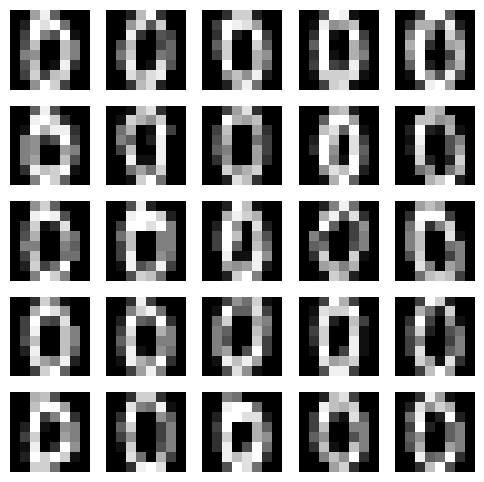

In [11]:
dataset = DigitsDataset(
    csv_file="D:\helpers\optdigits_csv (1).csv",
    label=0,
    transform=transforms.Compose([transforms.ToTensor()]),
)
sampler = RandomSampler(dataset, replacement=True, num_samples=25)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=1, drop_last=True, sampler=sampler
)

ax = plt.figure(figsize=(6, 6))
for index, image in enumerate(iter(dataloader)):
    plt.subplot(5, 5, index +   1)
    plt.imshow(image[0][0][0], cmap="gray")
    plt.axis("off")

In [12]:
def get_archstring(arch):
    return "".join([re.sub(r'[0-9]|\]|\[', '', s) for s in arch.copy()])

architectures = [
        ["var", "enc[2]", "var"],
        ["var", "var", "enc[2]", "var", "var"],
        ["var", "enc[1]", "var", "enc[3]", "var"],
        ["var", "var", "enc[1]", "var", "var", "enc[3]", "var", "var"],
        ["var", "enc[0]", "var", "enc[2]", "var", "enc[4]", "var"],
        ["var", "enc[1]", "var", "enc[3]", "var", "enc[5]", "var", "enc[7]", "var"],
]
archstrings = [get_archstring(s) for s in architectures]

In [13]:
def plot_loss(loss_in, ax):
    """
    loss_in: (steps, 2) for single run or (runs, steps, 2) for many
    columns: [D_loss_raw, G_loss]
    """
    arr = np.asarray(loss_in)
    ax.clear()

    if arr.size == 0:
        ax.text(0.5, 0.5, "No loss data", ha="center", va="center", transform=ax.transAxes)
        ax.set_title("Loss Evolution"); ax.set_xlabel("Iteration"); ax.set_ylabel("Loss Value")
        return

    if arr.ndim == 2:  # (steps,2)
        D = arr[:, 0] / 2.0
        G = arr[:, 1]
        ax.plot(D, label="D Loss")
        ax.plot(G, label="G Loss")
    elif arr.ndim == 3:  # (runs,steps,2)
        D = arr[:, :, 0] / 2.0
        G = arr[:, :, 1]
        ax.plot(D.T, alpha=0.15, lw=1)
        ax.plot(G.T, alpha=0.15, lw=1)
        ax.plot(D.mean(axis=0), label="D Loss (mean)", lw=2)
        ax.plot(G.mean(axis=0), label="G Loss (mean)", lw=2)
    else:
        ax.text(0.5, 0.5, f"Unexpected loss shape: {arr.shape}", ha="center", va="center", transform=ax.transAxes)

    ax.set_title("Loss Evolution")
    ax.set_xlabel("Iteration"); ax.set_ylabel("Loss Value"); ax.legend()

In [14]:
def _autocontrast_row(v, eps=1e-6, tol=5e-3):
    """v: (pixels,) -> [0,1] with robust contrast; mid-gray fallback if span is tiny."""
    x = np.asarray(v, dtype=np.float32)
    x = np.nan_to_num(x, nan=0.0, posinf=1.0, neginf=0.0)
    # light squash if clearly outside [0,1]
    if x.min() < 0.0 or x.max() > 1.0:
        x = 1.0 / (1.0 + np.exp(-x))
    x_min, x_max = float(x.min()), float(x.max())
    span = x_max - x_min
    if span >= tol:
        y = (x - x_min) / max(span, eps)
    else:
        xc  = x - x.mean()
        std = float(xc.std())
        y   = (xc / max(std, eps)) * 0.15 + 0.5
    return np.clip(y, 0.0, 1.0)

def _autocontrast_rows(arr):
    """arr: (steps,pixels) -> per-row autocontrast in [0,1]."""
    if arr.size == 0: return arr
    return np.stack([_autocontrast_row(r) for r in np.asarray(arr)], axis=0)

def _render_from_fake(fake_arr, axes):
    """Render last k evenly spaced frames from fake_arr (steps,pixels) onto axes."""
    if fake_arr is None or fake_arr.size == 0 or len(axes) == 0:
        for ax in axes: ax.axis("off")
        return
    arr = np.asarray(fake_arr)
    if arr.ndim != 2:
        arr = arr.reshape(-1, arr.shape[-1])
    steps, pixels = arr.shape
    k = len(axes)
    idxs = np.linspace(max(1, steps // 3), steps, num=k, endpoint=True, dtype=int) - 1
    idxs = np.clip(np.unique(idxs), 0, steps - 1)
    if len(idxs) < k:
        idxs = np.pad(idxs, (0, k - len(idxs)), mode="edge")
    for ax, t in zip(axes, idxs):
        img = _autocontrast_row(arr[t])
        img8 = np.clip(img * 255.0, 0, 255).astype(np.uint8).reshape(8, 8)
        ax.imshow(img8, cmap="gray"); ax.axis("off")

In [ ]:


def plot_progress(fake_runs, axes):
    """
    fake_runs:
      - (steps, pixels) for a single run
      - (runs, steps, pixels) for multiple runs
    axes: list of Axes; we render exactly len(axes) snapshots
    """
    arr = np.asarray(fake_runs)

    # clear axes
    for ax in axes:
        ax.clear()
        ax.axis("off")

    if arr.size == 0 or len(axes) == 0:
        return

    # unify to (runs, steps, pixels)
    if arr.ndim == 2:          # single run
        arr = arr[None, ...]   # -> (1, steps, pixels)
    elif arr.ndim != 3:
        axes[0].text(0.5, 0.5, f"Unexpected shape: {arr.shape}",
                     ha="center", va="center", transform=axes[0].transAxes)
        return

    runs, steps, pixels = arr.shape

    # optional smoothing like your original code
    if steps >= 4:
        chunks = [arr[:, i::4, :] for i in range(4)]              # list of (runs, ceil(steps/4), pixels)
        fake_mean = np.mean(np.mean(np.array(chunks), axis=0), axis=0)  # -> (ceil(steps/4), pixels)
    else:
        fake_mean = arr.mean(axis=0)  # (steps, pixels)

    steps2 = fake_mean.shape[0]
    k = len(axes)

    # choose exactly k evenly spaced snapshot indices
    idxs = np.linspace(1, steps2, num=k, endpoint=True, dtype=int) - 1
    idxs = np.clip(np.unique(idxs), 0, steps2 - 1)
    if len(idxs) < k:  # pad if uniq collapsed
        idxs = np.pad(idxs, (0, k - len(idxs)), mode="edge")

    for ax, t in zip(axes, idxs):
        img = _autocontrast_row(fake_mean[t])  # (pixels,) in [0,1]
        img8 = np.clip(img * 255.0, 0, 255).astype(np.uint8).reshape(8, 8)
        ax.imshow(img8, cmap="gray")
        ax.set_title(f"Iter {t}", fontsize=10)
        ax.axis("off")

    # row title
    axes[0].text(0.0, 1.10, "Image Evolution",
                 transform=axes[0].transAxes, ha="left", va="bottom", fontsize=12)




In [17]:
def plot_results(params_runs, config, axes, best_run=None):
    """
    params_runs: list of arrays; each is 1D (final params) or 2D (trajectory → take last row)
    """
    num_results = len(axes)
    if num_results == 0:
        return
    for ax in axes:
        ax.clear()
        ax.axis("off")

    if not params_runs:
        axes[0].set_title("Generated Images", fontsize=14, pad=10)
        return

    # Build a fresh QGAN with the SAME training config
    qgan = QGAN(
        image_size=8,
        gen_count=config["gen_count"],
        gen_arch=config["arch"],
        input_state=pcvl.BasicState(config["input_state"]),
        noise_dim=config["noise_dim"],
        batch_size=4,
        pnr=config["pnr"],
        lossy=False,
    )

    # Put G in eval mode for deterministic sampling
    qgan.G.eval()

    # If you saved trainable params, load them into G
    final_results = []
    for params in params_runs:
        p = np.asarray(params)
        p = p[-1] if p.ndim == 2 else p
        # If your generator exposes such a method:
        if hasattr(qgan.G, "update_var_params"):
            qgan.G.update_var_params(p)

        # >>> THE IMPORTANT FIX: use qgan.latent_dim, not noise_dim <<<
        z = np.random.normal(0, 2 * np.pi, (num_results, qgan.latent_dim))

        # Sample without autograd; clamp to [0,1]
        with torch.no_grad():
            z_t  = torch.from_numpy(z).float().to(qgan.device)
            out  = qgan.G(z_t).clamp(0.0, 1.0).cpu().numpy()  # shape: (num_results, 64)
        final_results.append(out)

    final_arr = np.stack(final_results, axis=0)  # (runs, num_results, 64)

    rng = np.random.default_rng()
    ss_rate = 6 if config["noise_dim"] == 1 else 5 if config["noise_dim"] == 2 else 4

    for i, ax in enumerate(axes):
        data = final_arr[:, i, :]  # (runs, 64)
        if best_run is not None and 0 <= best_run < data.shape[0]:
            image_flat = data[best_run]
        else:
            k = min(ss_rate, data.shape[0])
            idx = rng.choice(data.shape[0], size=k, replace=False)
            image_flat = data[idx].mean(axis=0)

        # Make sure we visualize correctly
        img = (np.clip(image_flat, 0.0, 1.0) * 255.0).astype(np.uint8).reshape(8, 8)
        ax.imshow(img, cmap="gray", vmin=0, vmax=255)
        ax.axis("off")

    axes[0].set_title("Generated Images", fontsize=14, pad=10)


In [57]:
from numpy.random import default_rng

varencvar


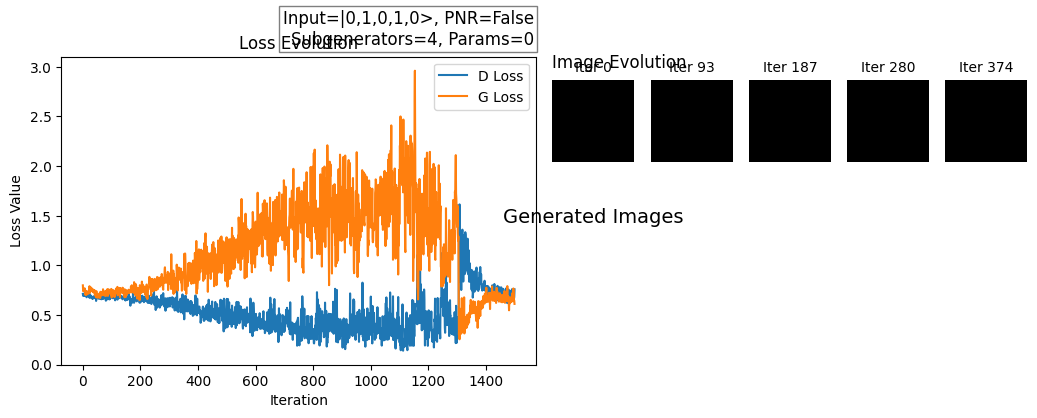

varvarencvarvar


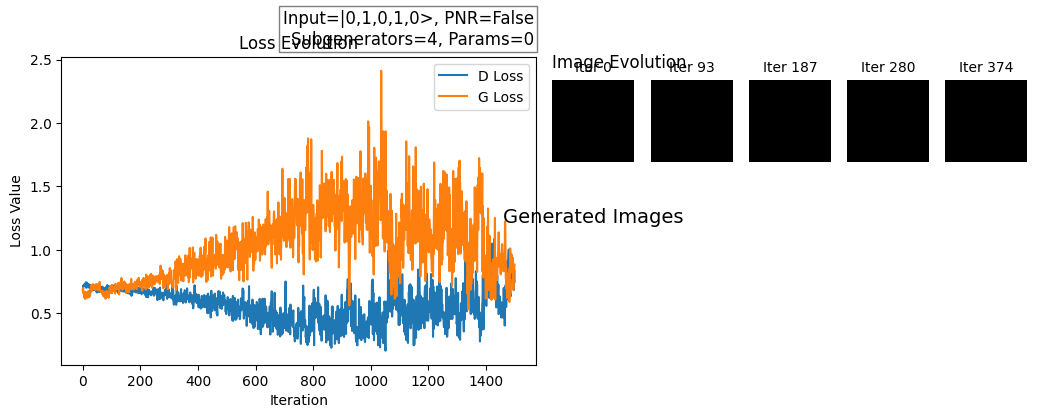

varencvarencvar


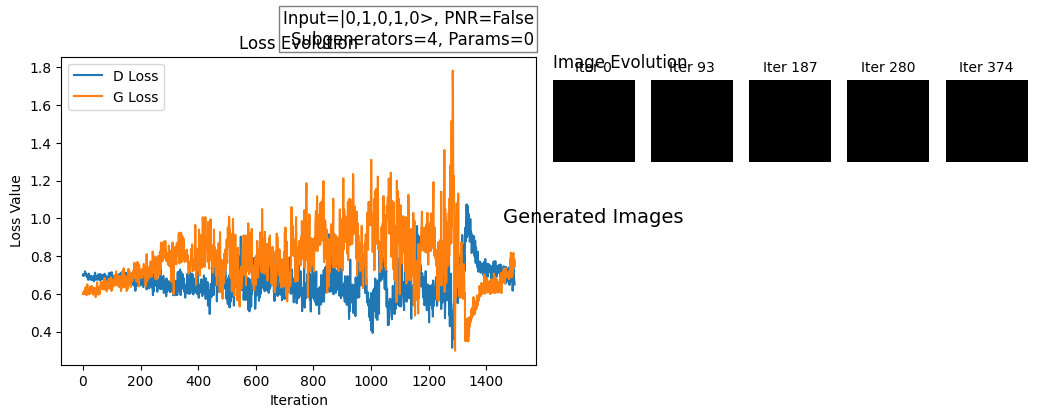

varvarencvarvarencvarvar
varencvarencvarencvar
varencvarencvarencvarencvar


In [18]:
RUN = 1  # fixed

for archstring in archstrings:
    print(archstring)
    for config_num in range(3):
        config_path = os.path.join(path, f"config_{config_num}")
        with open(os.path.join(config_path, "config.json")) as c:
            config = json.load(c)

        if get_archstring(config["arch"]) != archstring:
            continue

        full_path   = os.path.join(path, f"config_{config_num}", f"run_{RUN}")
        loss_file   = os.path.join(full_path, "loss_progress.csv")
        fake_file   = os.path.join(full_path, "fake_progress.csv")
        params_file = os.path.join(full_path, "G_params_progress.csv")

        loss_data   = np.loadtxt(loss_file, delimiter=",", skiprows=1) if os.path.exists(loss_file) else np.empty((0,))
        fake_data   = np.loadtxt(fake_file, delimiter=",")            if os.path.exists(fake_file) else np.empty((0,))
        params_data = np.loadtxt(params_file, delimiter=",")          if os.path.exists(params_file) else None

        fig = plt.figure(figsize=(15, 4))
        gs = fig.add_gridspec(2, 12)
        loss_ax   = fig.add_subplot(gs[:, :5])
        prog_axes = [fig.add_subplot(gs[0, 5+i]) for i in range(5)]
        res_axes  = [fig.add_subplot(gs[1, 5+i]) for i in range(5)]

        # loss: pass 2D if single run; otherwise stack if you ever add more runs
        plot_loss(loss_data, loss_ax)

        # progress: expects 2D (steps,pixels) or 3D; we have 2D for run=1
        plot_progress(fake_data, prog_axes)

        # generated images
        params_list = [params_data] if params_data is not None else []
        plot_results(params_list, config, res_axes, best_run=0 if params_list else None)

        n_params = (params_data.shape[-1]) if params_data is not None else 0
        configinfo = (
            f"Input={pcvl.BasicState(config['input_state'])}, PNR={config['pnr']}\n"
            f"Subgenerators={config['gen_count']}, Params={n_params}"
        )
        loss_ax.text(
            x=0.995, y=1.04, s=configinfo, ha="right",
            bbox=dict(boxstyle='square, pad=0.2', facecolor='white', alpha=0.5),
            transform=loss_ax.transAxes, fontsize=12
        )

        plt.subplots_adjust(hspace=0.4)

    plt.show()



varencvar


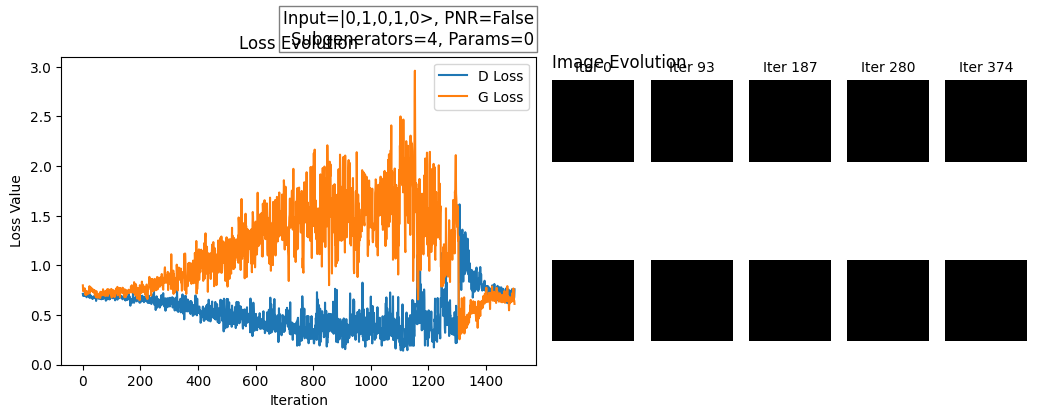

varvarencvarvar


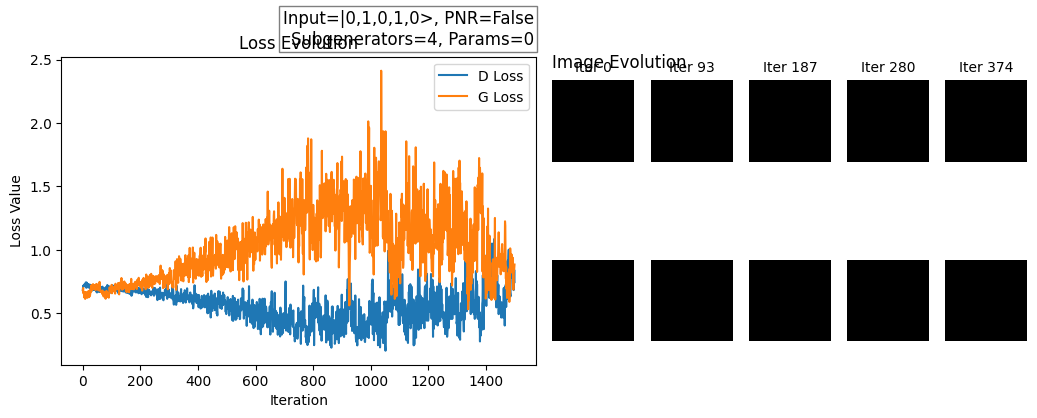

varencvarencvar


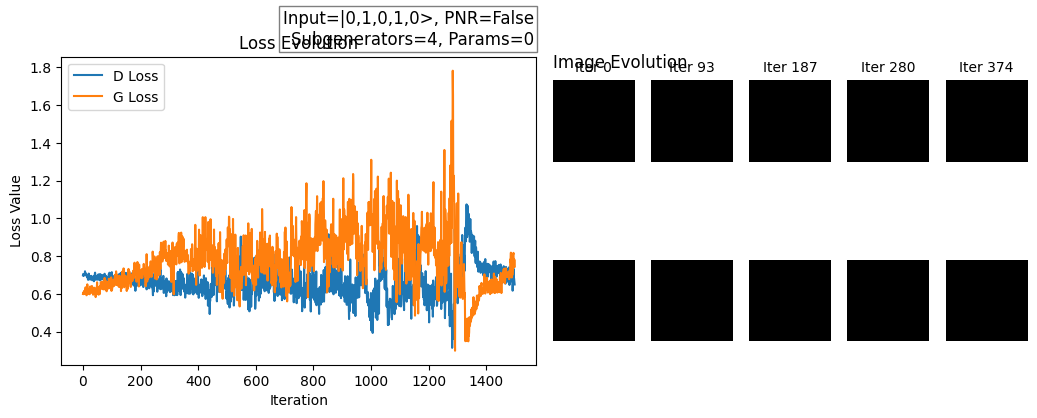

varvarencvarvarencvarvar
varencvarencvarencvar
varencvarencvarencvarencvar


In [19]:
RUN = 1  # fixed

for archstring in archstrings:
    print(archstring)
    for config_num in range(3):
        config_path = os.path.join(path, f"config_{config_num}")
        with open(os.path.join(config_path, "config.json")) as c:
            config = json.load(c)

        if get_archstring(config["arch"]) != archstring:
            continue

        full_path   = os.path.join(path, f"config_{config_num}", f"run_{RUN}")
        loss_file   = os.path.join(full_path, "loss_progress.csv")
        fake_file   = os.path.join(full_path, "fake_progress.csv")
        params_file = os.path.join(full_path, "G_params_progress.csv")

        # --- load (single run) ---
        loss_data   = np.loadtxt(loss_file, delimiter=",", skiprows=1) if os.path.exists(loss_file) else np.empty((0, 2))
        fake_data   = np.loadtxt(fake_file, delimiter=",")            if os.path.exists(fake_file) else np.empty((0, 64))
        params_data = np.loadtxt(params_file, delimiter=",")          if os.path.exists(params_file) else None

        # --- normalize shapes defensively ---
        if loss_data.ndim == 1 and loss_data.size >= 2:
            loss_data = loss_data[None, :]  # (1,2)

        if fake_data.ndim == 1:
            fake_data = fake_data[None, :]
        # force to 64 pixels (8x8) when possible
        if fake_data.size and fake_data.shape[1] != 64 and (fake_data.size % 64 == 0):
            steps = fake_data.shape[0]
            fake_data = fake_data.reshape(steps, -1)[:, :64]

        if params_data is not None and params_data.ndim == 1:
            params_data = params_data[None, :]  # (1,P)

        # --- figure & axes ---
        fig = plt.figure(figsize=(15, 4))
        gs = fig.add_gridspec(2, 12)
        loss_ax   = fig.add_subplot(gs[:, :5])
        prog_axes = [fig.add_subplot(gs[0, 5+i]) for i in range(5)]
        res_axes  = [fig.add_subplot(gs[1, 5+i]) for i in range(5)]

        # loss: pass 2D for single run
        plot_loss(loss_data, loss_ax)

        # progress: auto-contrast frames before plotting so they aren't black
        ac_fake = _autocontrast_rows(fake_data) if fake_data.size else fake_data
        plot_progress(ac_fake, prog_axes)

        # generated images:
        params_list = [params_data] if params_data is not None else []
        if params_list and params_list[0] is not None and params_list[0].size:
            # try your original plot_results first (if it regenerates from params)
            try:
                plot_results(params_list, config, res_axes, best_run=0)
            except Exception:
                # fallback to saved fakes if regeneration fails
                _render_from_fake(ac_fake, res_axes)
        else:
            # no params saved (Params=0) -> show saved fakes (auto-contrasted)
            _render_from_fake(ac_fake, res_axes)

        n_params = (params_data.shape[-1]) if params_data is not None else 0
        configinfo = (
            f"Input={pcvl.BasicState(config['input_state'])}, PNR={config['pnr']}\n"
            f"Subgenerators={config['gen_count']}, Params={n_params}"
        )
        loss_ax.text(
            x=0.995, y=1.04, s=configinfo, ha="right",
            bbox=dict(boxstyle='square, pad=0.2', facecolor='white', alpha=0.5),
            transform=loss_ax.transAxes, fontsize=12
        )

        plt.subplots_adjust(hspace=0.4)

    plt.show()

In [121]:
def plot_loss(loss_data, ax):
    D_loss = loss_data[:, 0] / 2
    G_loss = loss_data[:, 1]
    ax.plot(D_loss, label="D Loss")
    ax.plot(G_loss, label="G Loss")
    ax.set_title("Loss Evolution")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss Value")
    ax.legend()

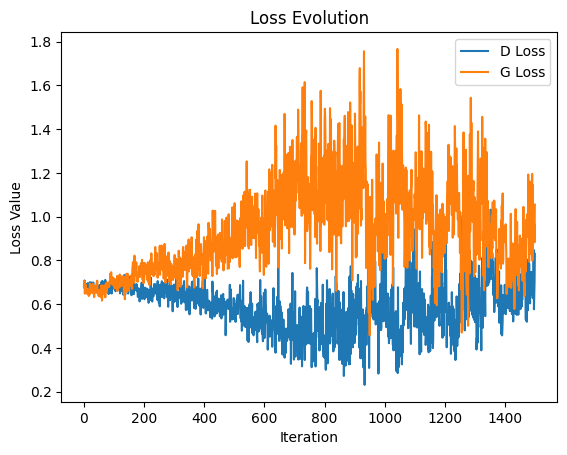

In [122]:
loss_data = np.loadtxt("ideal_merlin_1/config_0/run_1/loss_progress.csv", 
                       delimiter=",", skiprows=1)
fig, ax = plt.subplots()
plot_loss(loss_data, ax)
plt.show()